In [8]:
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import datetime as dt
import jax.numpy as jnp
from jax import lax, random, vmap

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation
az.style.use('fivethirtyeight')
date_dict = {
    0: 'Thứ hai',
    1: 'Thứ ba',
    2: 'Thứ tư',
    3: 'Thứ năm',
    4: 'Thứ sáu',
    5: 'Thứ bảy',
    6: 'Chủ nhật'
}
url1 = "outpatient_count_2019.csv"
url2 = "outpatient_count_2020.csv"

In [30]:
def read_df(url, year):
    df = pd.read_csv(url, index_col=0)
    df.index = pd.to_datetime(df.index, format="%Y%m%d")
    df["quarter"] = 0
    df["quarter"][df.index < dt.datetime(year,4,1)] = 1
    df["quarter"][(df.index >= dt.datetime(year,4,1)) & (df.index < dt.datetime(year,7,1)) ] = 2
    df["quarter"][(df.index >= dt.datetime(year,7,1)) & (df.index < dt.datetime(year,10,1)) ] = 3
    df["quarter"][df.index >= dt.datetime(year,10,1)] = 4
    df["weekday"] = df.index.weekday
    return df

def plot(predictive, year, ylim=(1000,2300)):
    fig, axs = plt.subplots(2,2, figsize=(15,10), sharey=True, sharex=True, subplot_kw={"ylim":ylim})
    for i, ax in enumerate(axs.flatten()):
        count_pred = vmap(
            lambda wd: predictive(random.PRNGKey(2), quarter=i+1, weekday=wd)["C"])(jnp.arange(7))
        count_mean = jnp.mean(count_pred, axis=1)
        count_CI = jnp.quantile(count_pred, jnp.array([0.025, 0.975]), axis=1)
        ax.bar(jnp.arange(7), count_mean, yerr=jnp.abs(count_CI-count_mean))
        ax.set(xticks=jnp.arange(7), xticklabels=date_dict.values(), ylabel="Lượt khám")
        ax.hlines(1500, -0.5, 6.5, linestyle="--", colors='r')
        ax.set_title(f"Quý {i+1}", y=0.8)
        ax.tick_params(axis="x", labelsize=10, labelrotation=45)
    axs[0,0].annotate("1500", (5, 1550), size=20, color="r")
    plt.suptitle(f"Số lượt khám ngoại trú trung bình của bệnh viện ABC năm {year}", size=30, y=0)
    plt.tight_layout();
    plt.show();
    return count_mean, count_CI

def model(quarter, weekday, count=None):
    aq = numpyro.sample("aq", dist.Normal(0, 10).expand([4]))
    aw = numpyro.sample("aw", dist.Normal(0, 10).expand([7]))
    lambda_ = numpyro.deterministic("lambda", jnp.exp(aq[quarter-1] + aw[weekday]))
    numpyro.sample("C", dist.Poisson(lambda_), obs=count)
    
def infer(df):
    guide = AutoLaplaceApproximation(model)
    svi = SVI(
        model,
        guide,
        optim.Adam(1),
        Trace_ELBO(),
        count=df["count"].values,
        quarter=df["quarter"].values,
        weekday=df["weekday"].values
    )
    param, losses = svi.run(random.PRNGKey(0), 1000)
    post = guide.sample_posterior(random.PRNGKey(1), param, (1000,))
    predictive = Predictive(model, post, return_sites=['C'])
    return guide, predictive

def compare(p1, p2):
    

100%|██████████| 1000/1000 [00:01<00:00, 562.96it/s, init loss: 2891572.0000, avg. loss [951-1000]: 7638.5093]


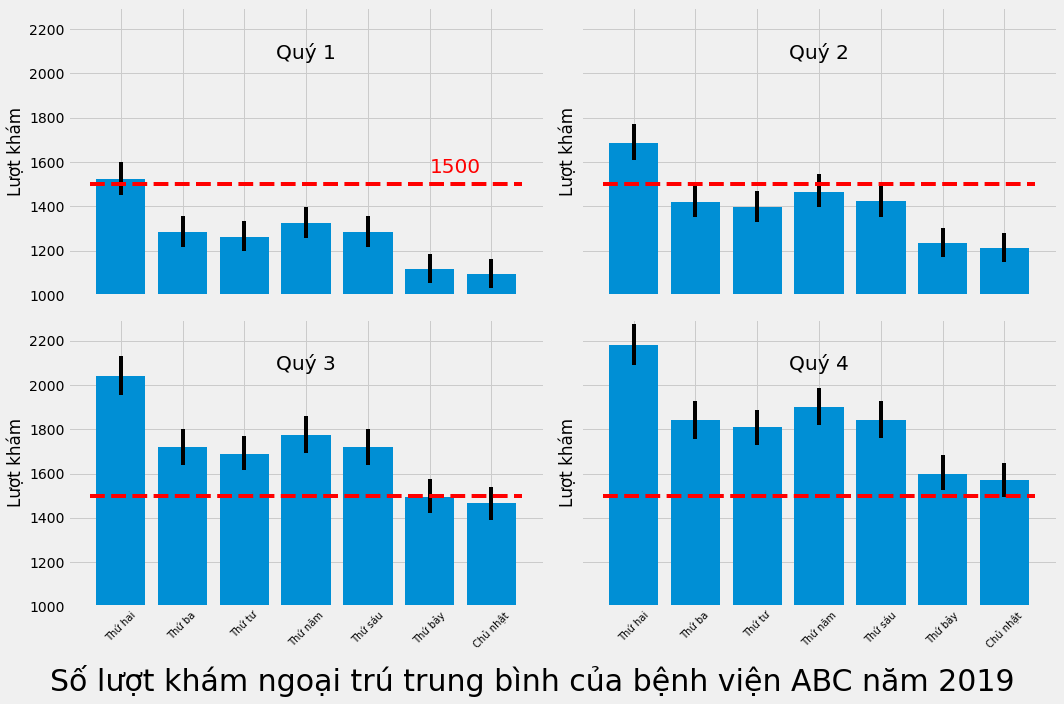

In [31]:
df1 = read_df(url1,2019)
m1, pred1 = infer(df1)
mean1, ci1 = plot(pred1,2019)

In [32]:
mean1

DeviceArray([2182.429, 1840.092, 1808.243, 1899.08 , 1841.275, 1599.412,
             1568.941], dtype=float32)

100%|██████████| 1000/1000 [00:01<00:00, 642.17it/s, init loss: 2341039.2500, avg. loss [951-1000]: 20331.9668] 


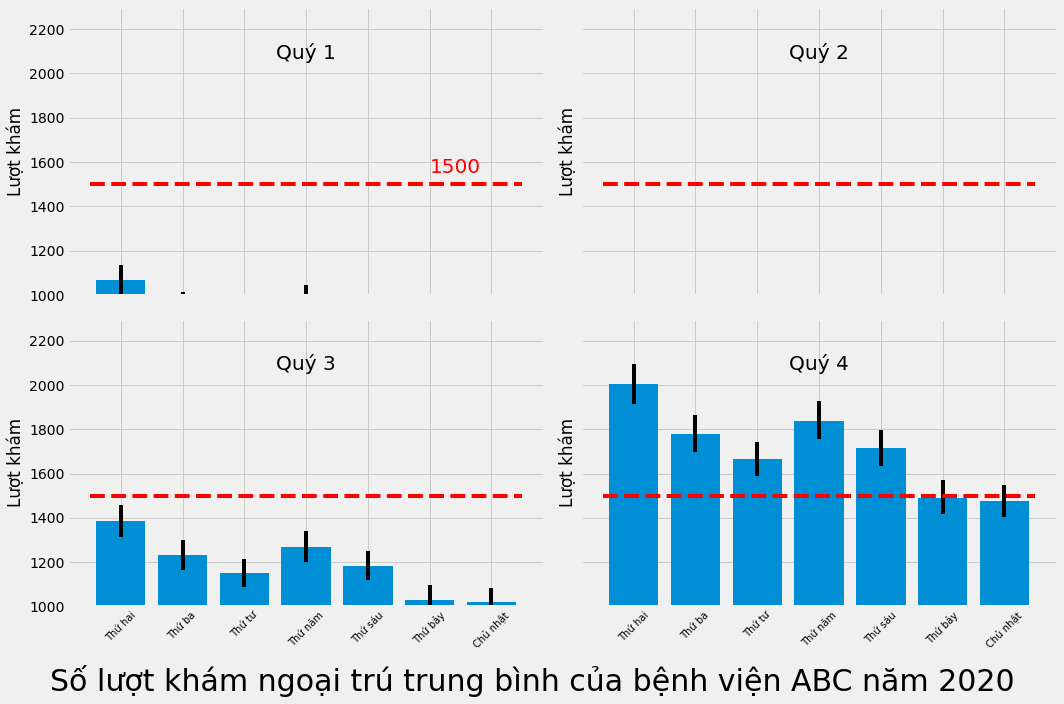

(DeviceArray([2004.986, 1780.12 , 1664.834, 1838.733, 1713.858, 1490.932,
              1475.002], dtype=float32),
 Buffer([[1915.975, 1697.   , 1589.   , 1757.975, 1635.   , 1418.   ,
          1402.   ],
         [2095.05 , 1865.025, 1743.   , 1926.   , 1795.05 , 1572.   ,
          1549.025]], dtype=float32))

In [33]:
df2 = read_df(url2, 2020)
m2, pred2 = infer(df2)
plot(pred2,2020)